In [1]:
# this file is for model performance comparsion

In [2]:
#import useful package
from __future__ import print_function
import os
import argparse
import shutil

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
from torchvision import datasets, transforms

import models
from torchinfo import summary

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [3]:
# set up device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# baseline model
base_model = models.resnet()
base_model = base_model.to(device)

path = './checkpoint/baseline/baseline_model_best.pth.tar'
print("=> loading checkpoint '{}'".format(path))
checkpoint = torch.load(path,map_location=device)
base_model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint './checkpoint/baseline/baseline_model_best.pth.tar'


<All keys matched successfully>

In [6]:
# final model 
path = './checkpoint/prune/pruned.pth.tar'
checkpoint = torch.load(path)
final_model = models.resnet(cfg=checkpoint['cfg'])
final_model = final_model.to(device)
path = './checkpoint/finetune/finetune_model_best.pth.tar'
print("=> loading checkpoint '{}'".format(path))
checkpoint = torch.load(path,map_location=device)
final_model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint './checkpoint/finetune/finetune_model_best.pth.tar'


<All keys matched successfully>

In [10]:
def plot_confusion_matrix(labels, pred_labels, classes,name):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    plt.savefig("./checkpoint/" + name)
    
def eval_peformance(net,name):
    criterion = nn.CrossEntropyLoss()
    net.eval()
    test_loss = 0
    correct = 0

    labels = []
    probs = []
    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            output = net(data)

            loss = criterion(output, target)
            test_loss += loss.item() # sum up batch loss

            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            labels.append(target)
            probs.append(pred)

    test_loss /= len(test_loader.dataset)
    test_acc = correct / float(len(test_loader.dataset))
    
    num_parameters = sum([param.nelement() for param in net.parameters()])
    print('\n num of parameters in model:'+str(num_parameters))
    print('\n Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. *test_acc))

    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    
    plot_confusion_matrix(labels.cpu(), probs.cpu(), classes,name) 



 num of parameters in model:11105866

 Test set: Average loss: 0.0027, Accuracy: 9378/10000 (93.8%)



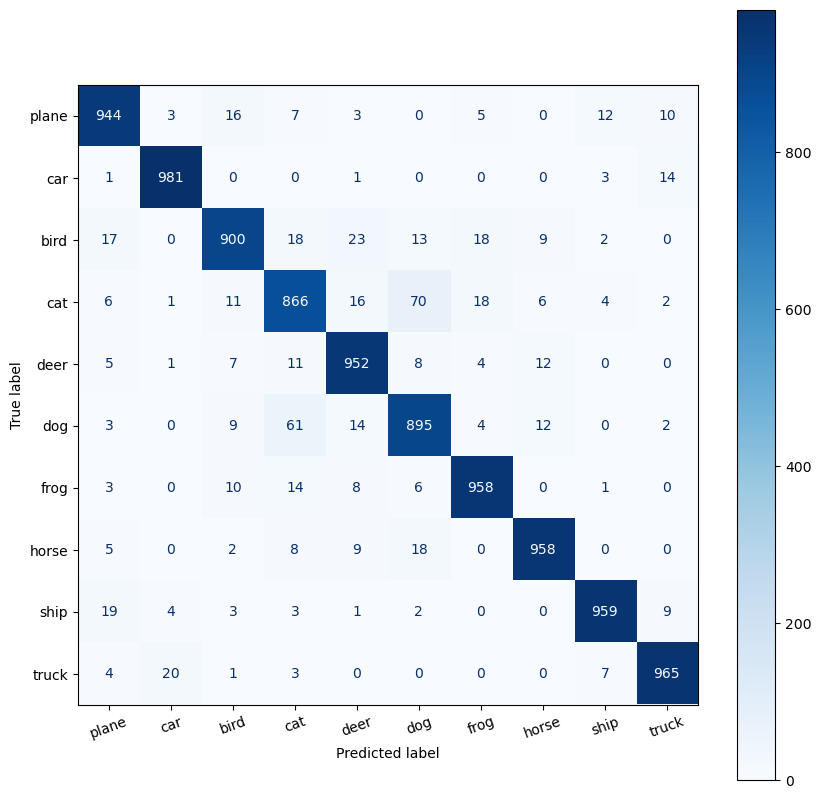

In [11]:
eval_peformance(base_model,"baseline_confusion_matrix.png")


 num of parameters in model:4558938

 Test set: Average loss: 0.0029, Accuracy: 9323/10000 (93.2%)



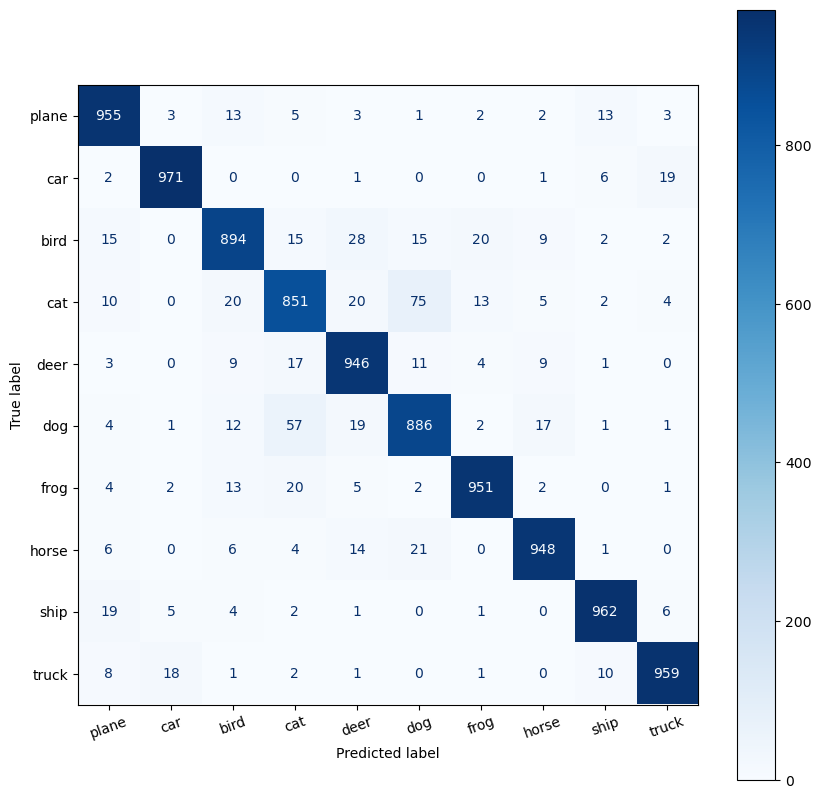

In [12]:
eval_peformance(final_model,"finetune_confusion_matrix.png")